# Comparison of different methods to create dataset

Import dependencies

In [1]:
# Standard Library
import os, sys
import glob, shutil

# PyPI dependencies
import cv2
import chainercv
import imageio

import numpy as np
import ipywidgets as wgt
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from sklearn.manifold import TSNE
from sklearn import preprocessing
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from cvt.models import SubspaceMethod, KernelMSM

# Confirm we are working in the correct directory.
path = '/home/atom/emotion/' # change this to the correct path
if os.getcwd().split(os.sep)[-1] != 'emotion':
    os.chdir(path)
assert os.getcwd().split(os.sep)[-1] == 'emotion', 'please set the correct path. Current: {0}'.format(os.getcwd())

import atomity

# import JVAER tools
from JAVER import utils
from JAVER import scrape_tools
from JAVER import track_tools

In [2]:
import JAVER
import importlib

importlib.reload(JAVER.utils)
importlib.reload(JAVER.track_tools)
importlib.reload(JAVER.scrape_tools)
importlib.reload(JAVER.logger);

## Downloading images and videos

We download images using the google_images_download package and we download videos using the pytube package.
Pytube frequently breaks because of the frequent changes youtube makes and is not very stable. If it suddenly doesn't work I recommend checking their github repo for issues.

Estimate time for downloading,

- images <2 secs per image
- videos <1 min per video

I don't think this will become a bottle neck.

In [4]:
# Choose paths to save data
out_dir_path = './notebooks/single_person_results'

# Set up save directories
dirs1 = ['images', 'videos', 'embeddings', 'cropped_images', 'inliers', 'outliers', 'video_frames', 'new_videos']
query = input('Enter Query: ')
JAVER.utils.make_save_dirs(out_dir_path, dirs1, [query], overwrite=True)

n_images = int(input('Enter number of images to scrape: ')) # Number of images of each person to scrape
chromedriver_path = 'JAVER/chromedriver' # path to chromedriver

# get_face_images frequently fails to get n_images, it will usually get more than 80%
# if there are 0 images found it will recurse and try again.
with atomity.timing():
    JAVER.scrape_tools.get_face_images(query, n_images, os.path.join(out_dir_path, 'images'), chromedriver_path)

Enter Query: Elon Musk
Enter number of images to scrape: 80


[2020-02-25 02:44:24,050] INFO @ line 66: Success: Loaded 80 images.


Time: 58.03652811050415


In [5]:
n_videos = 1 # Number of images of each person to scrape
with atomity.timing():
    video_paths = JAVER.scrape_tools.get_yt_videos(query, os.path.join(out_dir_path, 'videos'), n_videos)

[2020-02-25 02:45:33,473] INFO @ line 115: Successfully downloaded 1 videos.


Time: 69.41674709320068


In [6]:
paths = glob.glob('./notebooks/single_person_results/images/Elon Musk/*')
atomity.browse_images(paths);

interactive(children=(Dropdown(description='image_path', options=('./notebooks/single_person_results/images/El…

## Face detection

In [7]:
in_paths = glob.glob(r'./notebooks/single_person_results/images/*/*.jpg')
out_paths = [p.replace('{0}images{0}'.format(os.sep), '{0}cropped_images{0}'.format(os.sep)) for p in in_paths]

with atomity.timing():
    _ = utils.crop_faces(in_image_paths=in_paths, out_paths=out_paths)

[2020-02-25 02:45:47,318] INFO @ line 120: using: cuda:0


Time: 17.700697898864746


In [8]:
paths = glob.glob('./notebooks/single_person_results/cropped_images/Elon Musk/*')
atomity.browse_images(paths);

interactive(children=(Dropdown(description='image_path', options=('./notebooks/single_person_results/cropped_i…

## Face Embedding

In [9]:
in_paths = glob.glob(r'./notebooks/single_person_results/cropped_images/*/*.jpg')
out_paths = [p.replace('{0}cropped_images{0}'.format(os.sep), '{0}embeddings{0}'.format(os.sep)) for p in in_paths]

with atomity.timing():
    _ = utils.embed_faces(in_paths, out_paths, return_values=[])

[2020-02-25 02:46:33,300] INFO @ line 203: using: cuda:0


Time: 4.5799360275268555


## Outlier Detection

In [10]:
embeddings = np.zeros((0,512))
embedding_paths = glob.glob(r'./notebooks/single_person_results/embeddings/{0}/*.npy'.format(query))
in_paths = glob.glob(r'./notebooks/single_person_results/cropped_images/{0}/*.jpg'.format(query))
assert len(embedding_paths) == len(in_paths)
for path in embedding_paths:
    embeddings = np.vstack((embeddings, np.load(path)))

inlier_idx, outlier_idx = JAVER.utils.detect_outliers(embeddings)

for idx in outlier_idx:
    shutil.copyfile(in_paths[idx], in_paths[idx].replace('cropped_images', 'outliers'))
    os.remove(embedding_paths[idx])# remove outlying embeddings

for idx in inlier_idx:
    shutil.copyfile(in_paths[idx], in_paths[idx].replace('cropped_images', 'inliers'))

[2020-02-25 02:46:46,446] INFO @ line 276: 10% are outliers


In [11]:
paths = glob.glob('./notebooks/single_person_results/inliers/Elon Musk/*')
atomity.browse_images(paths);

interactive(children=(Dropdown(description='image_path', options=('./notebooks/single_person_results/inliers/E…

In [12]:
paths = glob.glob('./notebooks/single_person_results/outliers/Elon Musk/*')
atomity.browse_images(paths);

interactive(children=(Dropdown(description='image_path', options=('./notebooks/single_person_results/outliers/…

## Facial Tracking

In [13]:
def format_input(X, y):
    X = [X[np.where(y==t)] for t in np.unique(y)]
    return X, np.unique(y)

in_paths = glob.glob(r'./notebooks/single_person_results/embeddings/*/*.npy')

In [14]:
# load reference face
x, y = np.zeros((0,512)), []
for path in in_paths:
    label = 1 if os.path.basename(os.path.dirname(path)) == query else 0
    x = np.vstack((x, np.load(path)))
    y.append(label)

# use SM for face matching
SM = SubspaceMethod(n_subdims=5)
SM.fit(*format_input(x, y))

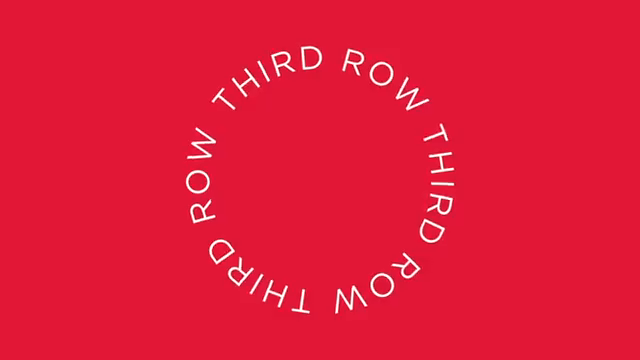

In [4]:
video_path = './notebooks/single_person_results/videos/Elon Musk/0.mp4'
video = imageio.get_reader(video_path,  'ffmpeg') # fails sometimes ? 
n_frames = video.count_frames()

@wgt.interact(Frame=range(1, n_frames, 10000))
def peek_video(Frame):
    display(Image.fromarray(video.get_data(Frame)))

In [52]:
import JAVER
import importlib

importlib.reload(JAVER.utils)
importlib.reload(JAVER.track_tools)
importlib.reload(JAVER.scrape_tools)
importlib.reload(JAVER.logger);

In [53]:
face_tracker = track_tools.FaceTracker(
    image_size=160,
    video_path = video_path,
    batch_size=100,
    step=100,
)

In [ ]:
tqdm._instances.clear()

face_tracker.track()

  0%|          | 1300/387094 [02:23<11:52:02,  9.03it/s]

In [129]:
tqdm._instances.clear()

# init loop
vid.set_image_index(0)

batch_size = 100
image_batch = []

# loop video framesa
for i in tqdm(range(0, n_frames, batch_size), total=n_frames):   
    
    image = vid.get_next_data()
    if i % batch_size == 0:
        image_batch.append(image)

    if len(image_batch) == batch_size:
        boxes, probs = track_tools.mtcnn(images=image_batch)
        
        if l := probs.co:
            print(probs)
            break
        image_batch = []
        
    for _ in range(batch_size):
        pass
    
    pass

#         image = Image.fromarray(im)
#         ret_dict = utils.crop_faces(images=[image], return_values=['bboxes', 'rois'])
        
#         bboxes = ret_dict['bboxes']
#         rois = ret_dict['rois']
#         embeddings = utils.embed_faces(images=rois, return_values='embeddings')['embeddings']
#         assert len(bboxes) == len(embeddings)

#         draw = ImageDraw.Draw(image)

#         for n in range(len(bboxes)):
            
#             bbox = bboxes[n]
#             x1,y1,x2,y2 =bboggggggggggggggggggggx
#             roi = rois[n]
#             embedding = embeddings[n]

#             proba = SM.predict_proba(embedding).squeeze()
#             text = 'proba: {0}\n {1}'.format(proba, 'Elon' if proba >= 0.7 else 'Not Elon')
#             font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf", 18, encoding="unic")

#             rect = (x1, y1, x1, y2, x2, y2, x2,y1, x1, y1)
#             draw.line(rect, width=5, fill='Red')
#             draw.text(xy=(x1, y1), text=text, fill='white', font=font)
            
#         image.save('./notebooks/single_person_results/video_frames/Elon Musk/' +str(i).zfill(6)+ ".png", "png")

  0%|          | 250/387094 [04:10<107:48:06,  1.00s/it]


[list([None]) list([None]) list([None]) list([None]) list([None])
 list([None]) list([None]) list([None]) list([None]) list([None])
 list([None]) list([None]) list([None]) list([None]) list([None])
 list([None]) list([None]) list([None]) list([None]) list([None])
 list([None]) list([None]) list([None]) list([None]) list([None])
 list([None]) list([None]) list([None]) list([None]) list([None])
 list([None]) list([None]) list([None]) list([None]) list([None])
 list([None]) list([None]) list([None]) list([None]) list([None])
 array([0.99999177, 0.99999785, 0.99998164, 0.99998212])
 array([0.99999058, 0.99999189, 0.9998399 , 0.99996197])
 array([0.99994087, 0.99989474, 0.99999607, 0.99997568])
 array([0.99999726, 0.99955624, 0.99999321])
 array([0.99999738, 0.99902189, 0.99697638])
 array([0.99994922, 0.99999678, 0.99896228, 0.99929273])
 array([0.99997652, 0.99999356, 0.99989593, 0.99935764])
 array([0.99997079, 0.9991309 , 0.99745721, 0.99999332])
 array([0.99999082, 0.99936146])
 array(

  0%|          | 200/387094 [00:13<13:37:46,  7.89it/s]

In [ ]:
#         vid_writer.write(np.asarray(image))
#     if i!=0 and i % 1000 == 0:
#         break
# vid_writer.release()


#                 if prev_bbox is None:
#                     if len(embeddings) == 1:
                        
#                         if SM.predict(embeddings):
#                             text = 'proba: {0}, {1}'.format(proba, 'Elon' if proba < 0.8 else 'Not Elon')
#                     else:
#                         continue                
#                 else:                
#                     candidate_idx = np.where(SM.predict(embeddings)==1)
#                     candidate_rois = rois[candidate_idx]
#                     candidate_bboxes = bboxes[candidate_idx]
#                     print(candidate_bboxes)

            # TODO Add chunk to list
#             print('Mean of frame {0} is {1}, {2}, {3}'.format(i, im.mean(), type(im), im.shape))

            # TODO: face detection
            # Get list of all face bboxes in one frame
#             

            # TODO: Association with IoU and Embeddings


            # TODO Add chunk to list

        # TODO split vid to chunks


In [23]:
image_folder = './notebooks/single_person_results/video_frames/Elon Musk'
video_name = './notebooks/single_person_results/movie.avi'

images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")])
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 25, (width,height))

for i in tqdm(range(len(images))):
    image = images[i]
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()


100%|██████████| 2456/2456 [00:21<00:00, 113.67it/s]


In [29]:
paths = glob.glob('./notebooks/single_person_results/new_vid_frames/Elon Musk/*')
atomity.browse_images(paths);

interactive(children=(Dropdown(description='image_path', options=(), value=None), Output()), _dom_classes=('wi…